In [93]:
import pandas as pd 


In [94]:
df=pd.read_csv('./data//reviews/final_data_reviws.csv')


## Descriptive analysis

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98977 entries, 0 to 98976
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   city             98977 non-null  object
 1   category         98977 non-null  object
 2   place name       98977 non-null  object
 3   date             96210 non-null  object
 4   note             96336 non-null  object
 5   review           92292 non-null  object
 6   sentiment_label  98977 non-null  object
 7   plateforme       98977 non-null  object
dtypes: object(8)
memory usage: 6.0+ MB


In [124]:
df.head(5)

,city,category,place_name,date,note,review,sentiment_label,plateforme,text
0,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaT,NaN,Naima and Sami were very friendly people who h...,positive,Tripadvisor,Naima and Sami were very friendly people who h...
1,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaT,NaN,Excellent stay at the conveniently situated Mo...,positive,Tripadvisor,Excellent stay at the conveniently situated Mo...
2,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaT,NaN,An impressive hall with EN-suite facilities an...,positive,Tripadvisor,An impressive hall with EN-suite facilities an...
3,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaT,NaN,We stayed at the Movenpick hotel where we met ...,positive,Tripadvisor,We stayed at the Movenpick hotel where we met ...
4,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaT,NaN,Hotel on top! Great location and with great se...,positive,Tripadvisor,Hotel on top! Great location and with great se...


In [102]:
dt = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)
df["date"]=dt.dt.to_period("M").dt.to_timestamp()

C:\Users\masta\AppData\Local\Temp\ipykernel_8356\43687208.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(df["date"], errors="coerce", dayfirst=True, infer_datetime_format=True)


In [ ]:
df['date'] = df['date'].dt.strftime('%m/%Y')

In [106]:
df.describe()

,city,category,place name,date,note,review,sentiment_label,plateforme
count,98977,98977,98977,96210,96336,92292,98977,98977
unique,17,3,3432,52,24,85447,3,3
top,Chefchaouen,hotel,Ecolodge L'île de Ouarzazate,09/2024,5.0/5,Bien,neutral,Google Maps
freq,11686,43191,150,16979,60124,192,86998,91643


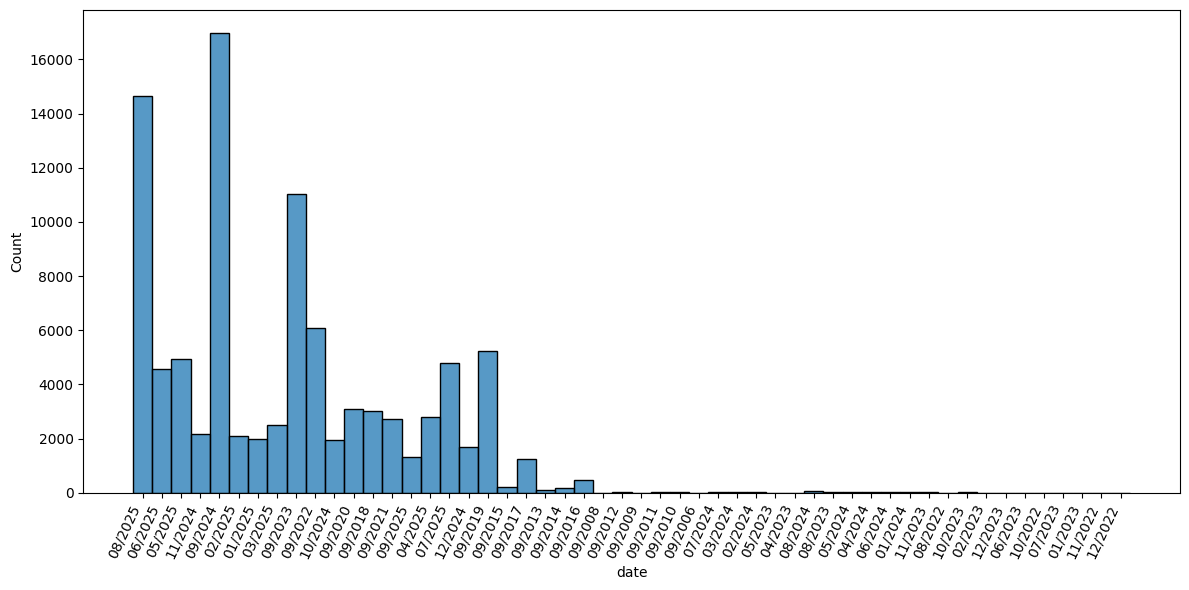

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,6))
sns.histplot(df["date"])
plt.xticks(rotation=65, ha='right', fontsize=10)  # Rotate and align x labels
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## fiting missing dates 

In [108]:
from __future__ import annotations
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Optional, Tuple, Dict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
from typing import Optional, Tuple, Dict, Set

In [109]:
# 0) Configuration & utilitaires
@dataclass
class ImputeCfg:
    start: str = "2010-01-01"   # borne min incluse
    end: str   = "2025-06-01"   # borne max incluse (mois de juin 2025)
    alpha: float = 0.5          # mix proba texte vs besoin restant (0..1)
    eps: float = 1e-6           # évite les 0 durs dans 'need'
    laplace: float = 1.0        # lissage Laplace pour saisonnalité
    min_train: int = 200        # nb min d'avis datés pour entraîner le classifieur
    random_state: int = 42      # seed
    # options vitesse/robustesse classifieur:
    max_train_rows: int = 30000 # sous-échantillonnage pour accélérer
    tfidf_min_df: int = 5       # ignore tokens trop rares
    tfidf_max_df: float = 0.95  # ignore tokens trop fréquents
    ngram_range: tuple = (1,1)  # unigrams = rapide et robuste
    C: float = 1.0              # régularisation LR
    max_iter: int = 200         # itérations max LR
    block_years_for_allocation: Set[int] = (2020,)
def to_month_floor(s: pd.Series) -> pd.Series:
    """Convertit une série de dates en timestamps au 1er du mois."""
    dt = pd.to_datetime(s, errors="coerce", dayfirst=True, infer_datetime_format=True)
    return dt.dt.to_period("M").dt.to_timestamp()


def stable_quota_allocation(weights: pd.Series, n_total: int) -> pd.Series:
    """Arrondi stable: on alloue des quotas entiers qui somment à n_total."""
    target = weights * float(n_total)
    floor = np.floor(target).astype(int)
    remainder = int(n_total - floor.sum())
    if remainder > 0:
        frac = (target - floor).sort_values(ascending=False)
        floor.loc[frac.index[:remainder]] += 1
    return floor


In [ ]:
def seasonal_raking(df: pd.DataFrame, cfg: ImputeCfg):
    calendar = pd.date_range(cfg.start, cfg.end, freq="MS")

    # 1) SAISONNALITÉ — utilise TOUTES les années (y compris 2020)
    obs = df.dropna(subset=["date"]).copy()
    if len(obs) == 0:
        season = pd.Series(1.0, index=range(1,13))
    else:
        obs["month_obs"] = to_month_floor(obs["date"])
        by_moy = (obs.groupby(obs["month_obs"].dt.month)
                    .size().reindex(range(1,13), fill_value=0).astype(float))
        season = by_moy + cfg.laplace
    season = season / season.sum()

    # 2) Projection sur tout le calendrier
    weights = pd.Series(index=calendar, data=[season[m] for m in calendar.month], dtype=float)

    # 3)  Bloquer 2020 (ou autres) pour l’ALLOCATION
    if cfg.block_years_for_allocation:
        mask_block = calendar.year.isin(cfg.block_years_for_allocation)
        weights.loc[mask_block] = 0.0

    # 4) Ré-normalisation des poids sur le calendrier restant
    total = weights.sum()
    if total == 0:
        # sécurité extrême: si on a tout bloqué par erreur, uniformiser sur les mois non bloqués
        mask_unblock = ~calendar.year.isin(cfg.block_years_for_allocation)
        weights.loc[mask_unblock] = 1.0
        weights.loc[~mask_unblock] = 0.0
        weights = weights / weights.sum()
    else:
        weights = weights / total

    # 5) Quotas (arrondi stable)
    n_missing = int(df["date"].isna().sum())
    quotas = stable_quota_allocation(weights, n_missing)
    return calendar, quotas


In [111]:
# 2) Classifieur du mois (cohérence locale PRO)
def fit_month_classifier(df: pd.DataFrame, cfg: ImputeCfg, rng) -> Optional[Pipeline]:
    """
    Entraîne un classifieur P(MoisDeLAnnee | Texte) si assez d'avis datés.
    - TF-IDF (unigram) + Logistic Regression multinomiale
    - Sous-échantillonne l'entraînement à max_train_rows pour la vitesse
    Retourne un Pipeline sklearn ou None s'il n'y a pas assez de données.
    """
    if "text" not in df.columns:
        return None
    train = df.dropna(subset=["date", "text"]).copy()
    if len(train) < cfg.min_train:
        return None

    # sous-échantillonnage (accélère si > max_train_rows)
    if len(train) > cfg.max_train_rows:
        train = train.sample(cfg.max_train_rows, random_state=cfg.random_state)

    train["moy"] = to_month_floor(train["date"]).dt.month.astype(int)

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True,
            strip_accents="unicode",
            analyzer="word",
            ngram_range=cfg.ngram_range,
            min_df=cfg.tfidf_min_df,
            max_df=cfg.tfidf_max_df
        )),
        ("lr", LogisticRegression(
            max_iter=cfg.max_iter,
            multi_class="multinomial",
            solver="lbfgs",
            C=cfg.C
        ))
    ])
    pipe.fit(train["text"].astype(str).values, train["moy"].values)
    return pipe

def month_proba_over_calendar(texts: pd.Series,
                              calendar: pd.DatetimeIndex,
                              pipe: Optional[Pipeline]) -> np.ndarray:
    """
    Donne une matrice P_i(t) (shape [n_missing, len(calendar)]).
    - Si pas de classifieur: proba uniforme
    - Sinon: proba(mois de l'année) -> mappée sur chaque mois du calendrier
    """
    n = len(texts); T = len(calendar)
    if n == 0:
        return np.zeros((0, T), dtype=float)
    if pipe is None:
        return np.full((n, T), 1.0/T, dtype=float)

    p_moy = pipe.predict_proba(texts.astype(str).values)  # [n, 12]
    idx = np.array([m - 1 for m in calendar.month])       # 1..12 -> 0..11
    P = p_moy[:, idx]
    P = np.clip(P, 1e-12, None)
    P = P / P.sum(axis=1, keepdims=True)
    return P

In [112]:
def constrained_sampling(P, quotas, cfg, rng):
    T = len(quotas); n = P.shape[0]
    quotas_left = quotas.astype(int).values.copy()
    assigned = np.zeros(T, dtype=int); choices = np.zeros(n, dtype=int)

    # Pré-calcul: index des mois bloqués (2020)
    # On reconstruit le calendrier à partir de quotas.index
    calendar = pd.DatetimeIndex(quotas.index) if not isinstance(quotas.index, pd.DatetimeIndex) \
               else quotas.index
    block_idx = np.where(calendar.year.isin(getattr(cfg, "block_years_for_allocation", set())))[0]

    order = rng.permutation(n)
    for _, i in enumerate(order):
        need = np.maximum(quotas_left - assigned, 0).astype(float) + cfg.eps
        # ⛔ force besoin=0 sur les mois bloqués
        if len(block_idx) > 0:
            need[block_idx] = 0.0

        if need.sum() <= cfg.eps:
            q = P[i]
        else:
            q = (P[i] ** cfg.alpha) * (need ** (1.0 - cfg.alpha))

        s = q.sum()
        q = (q / s) if np.isfinite(s) and s > 0 else np.full(T, 1.0/T, dtype=float)
        t = rng.choice(T, p=q)
        choices[i] = t
        assigned[t] += 1

    return choices


In [113]:
# 4) Pipeline principal
def impute_month_hybrid(df: pd.DataFrame, cfg: ImputeCfg) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Orchestration:
      A) raking -> quotas
      B) classifieur -> proba calendrier
      C) sampling contraint -> imputation
      + QC "observed/after/added" par mois
    """
    rng = check_random_state(cfg.random_state)

    # A) raking -> quotas
    calendar, quotas = seasonal_raking(df, cfg)

    # B) classifieur (optionnel si assez de datés)
    pipe = fit_month_classifier(df, cfg, rng)

    # masques
    dated_mask = df["date"].notna()
    missing_mask = ~dated_mask
    miss_idx = df.index[missing_mask].to_numpy()

    # init colonne month
    df_out = df.copy()
    df_out["month"] = pd.NaT
    df_out.loc[dated_mask, "month"] = to_month_floor(df_out.loc[dated_mask, "date"])

    # C) assignation pour NA
    if len(miss_idx) > 0:
        P = month_proba_over_calendar(df_out.loc[miss_idx, "text"], calendar, pipe)
        choices = constrained_sampling(P, quotas, cfg, rng)
        df_out.loc[miss_idx, "month"] = calendar[choices]

    # bornage & assert
    df_out["month"] = pd.to_datetime(df_out["month"], errors="coerce")
    df_out.loc[df_out["month"] < calendar.min(), "month"] = calendar.min()
    df_out.loc[df_out["month"] > calendar.max(), "month"] = calendar.max()
    assert df_out["month"].notna().all(), "Il reste des NA dans 'month' !"

    # QC
    obs_hist = to_month_floor(df_out.loc[dated_mask, "date"])
    obs_hist = obs_hist.groupby(obs_hist).size().reindex(calendar, fill_value=0).rename("observed").astype(int)
    after_hist = df_out.groupby("month").size().reindex(calendar, fill_value=0).rename("after").astype(int)
    qc = pd.concat([obs_hist, after_hist], axis=1)
    qc["added"] = qc["after"] - qc["observed"]

    info = {
        "n_total": int(len(df_out)),
        "n_obs": int(dated_mask.sum()),
        "n_missing": int(missing_mask.sum()),
        "calendar_len": int(len(calendar)),
        "alpha": cfg.alpha,
        "laplace": cfg.laplace,
        "used_classifier": bool(pipe is not None)
    }
    return df_out, qc, info

In [114]:

# 1) Charger ton fichier

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# 2) Choisir/Créer les colonnes 'date' et 'text'
# - 'date': détecte ta meilleure colonne date-like et convertis en datetime
# - 'text': choisis la colonne texte (review/comment/avis), sinon crée ""
date_like = [c for c in df.columns if any(k in c for k in ["date","time","posted","publish","created","updated"])]
best = max(date_like, key=lambda c: pd.to_datetime(df[c], errors="coerce", dayfirst=True).notna().mean()) if date_like else None
df["date"] = pd.to_datetime(df[best], errors="coerce", dayfirst=True) if best else pd.NaT

text_pref = ["review_text","text","comment","content","avis","review","message","body","description"]
text_col = next((c for c in text_pref if c in df.columns), None)
df["text"] = df[text_col].astype(str) if text_col else ""

# 3) Imputer
cfg = ImputeCfg(alpha=0.5, random_state=11)
df_imp, qc, info = impute_month_hybrid(df[["date","text"]], cfg)

# 4) Sauvegarder
out1 = "data/reviews_month_imputed_hybrid.csv"
out2 = "data/imputation_qc_summary.csv"
df_out = df.copy()
df_out["month"] = df_imp["month"]
df_out.to_csv(out1, index=False, encoding="utf-8")
qc.to_csv(out2, index=True, encoding="utf-8")
print("Info:", info)
print("Sauvé:", out1, out2)

C:\Users\masta\AppData\Local\Temp\ipykernel_8356\1646195395.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  best = max(date_like, key=lambda c: pd.to_datetime(df[c], errors="coerce", dayfirst=True).notna().mean()) if date_like else None
C:\Users\masta\AppData\Local\Temp\ipykernel_8356\1646195395.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  best = max(date_like, key=lambda c: pd.to_datetime(df[c], errors="coerce", dayfirst=True).notna().mean()) if date_like else None
C:\Users\masta\AppData\Local\Temp\ipykernel_8356\1646195395.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please speci

Info: {'n_total': 98977, 'n_obs': 96210, 'n_missing': 2767, 'calendar_len': 186, 'alpha': 0.5, 'laplace': 1.0, 'used_classifier': True}
Sauvé: data/reviews_month_imputed_hybrid.csv data/imputation_qc_summary.csv


In [116]:
df_out['month'] = df_out['month'].dt.strftime('%m/%Y')

In [118]:
df_out['date'] = df_out['date'].dt.strftime('%m/%Y')

In [119]:
df_out

,city,category,place_name,date,note,review,sentiment_label,plateforme,text,month
0,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaN,NaN,Naima and Sami were very friendly people who h...,positive,Tripadvisor,Naima and Sami were very friendly people who h...,09/2014
1,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaN,NaN,Excellent stay at the conveniently situated Mo...,positive,Tripadvisor,Excellent stay at the conveniently situated Mo...,09/2018
2,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaN,NaN,An impressive hall with EN-suite facilities an...,positive,Tripadvisor,An impressive hall with EN-suite facilities an...,09/2014
3,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaN,NaN,We stayed at the Movenpick hotel where we met ...,positive,Tripadvisor,We stayed at the Movenpick hotel where we met ...,01/2019
4,Marrakech,hotel,Movenpick Hotel Mansour Eddahbi Marrakech,NaN,NaN,Hotel on top! Great location and with great se...,positive,Tripadvisor,Hotel on top! Great location and with great se...,07/2022
...,...,...,...,...,...,...,...,...,...,...
98972,Dakhla,hotel,Hôtel Mansour\nUne nouvelle fenêtre va s'ouvrir,12/2024,4.0/5,Très bien | Positive: L'hôtel est situé dans u...,positive,Booking,Très bien | Positive: L'hôtel est situé dans u...,12/2024
98973,Dakhla,hotel,Hôtel Mansour\nUne nouvelle fenêtre va s'ouvrir,11/2024,3.5/5,Fabuleux | Positive: Le personnel de l’hôtel e...,negative,Booking,Fabuleux | Positive: Le personnel de l’hôtel e...,11/2024
98974,Dakhla,hotel,Hôtel Mansour\nUne nouvelle fenêtre va s'ouvrir,10/2024,4.5/5,Bien | Positive: Pas grand chose | Negative: R...,positive,Booking,Bien | Positive: Pas grand chose | Negative: R...,10/2024
98975,Dakhla,hotel,Hôtel Mansour\nUne nouvelle fenêtre va s'ouvrir,10/2024,4.0/5,Dommage je suis arrivé en plein travaux | Posi...,neutral,Booking,Dommage je suis arrivé en plein travaux | Posi...,10/2024


In [120]:
qc

,observed,after,added
2010-01-01,0,15,15
2010-02-01,0,4,4
2010-03-01,0,5,5
2010-04-01,0,6,6
2010-05-01,0,10,10
...,...,...,...
2025-02-01,2086,2090,4
2025-03-01,2513,2518,5
2025-04-01,2791,2797,6
2025-05-01,4945,4955,10
